In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')
import seaborn as sns
import numpy as np
import flatiron_stats as fs
%matplotlib inline

import scipy.stats as stats

from statsmodels.stats.power import TTestIndPower, TTestPower
from pandasql import sqldf

In [2]:
pysqldf = lambda q: sqldf(q, globals())# to pass in SQL queries in the form of a string to directly query our database.  

### Building functions for statistical testing

### Welch's t-test
Use: To compare means between two samples
Assumption: Two populations represented by the two given samples have normal distributions. Two samples have unequal variances and sizes. If two samples have same sizes and equal variances, the result of the test will be identical to student's t-test.

In [135]:
def welch_t(exp, cont):
    
    """ Calculate Welch's t statistic for two samples. """

    numerator = exp.mean() - cont.mean()
    
    # “ddof = Delta Degrees of Freedom”: the divisor used in the calculation is N - ddof, 
    #  where N represents the number of elements. By default ddof is zero.
    
    denominator = np.sqrt(exp.var(ddof=1)/exp.size + cont.var(ddof=1)/cont.size)
    
    return np.abs(numerator/denominator)

def welch_df(exp, cont):
    
    """ Calculate the effective degrees of freedom for two samples. This function returns the degrees of freedom """
    
    s1 = exp.var(ddof=1) 
    s2 = cont.var(ddof=1)
    n1 = exp.size
    n2 = cont.size
    
    numerator = (s1/n1 + s2/n2)**2
    denominator = (s1/ n1)**2/(n1 - 1) + (s2/ n2)**2/(n2 - 1)
    
    return numerator/denominator


def p_value_welch_ttest(exp, cont, two_sided=False):
    """Calculates the p-value for Welch's t-test given two samples.
    By default, the returned p-value is for a one-sided t-test. 
    Set the two-sided parameter to True if you wish to perform a two-sided t-test instead.
    """
    t = welch_t(exp, cont)
    df = welch_df(exp, cont)
    
    p = 1-stats.t.cdf(np.abs(t), df)
    
    if two_sided:
        return 2*p
    else:
        return p

In [164]:
def welch_summary(dict_dfs, alpha =0.5,two_sided=False):
    """
        The function 
        takes :
        dic_dfs ={group1: pandas.Series, group2:pandas.Series }
            note: group1 is the experimental group and group2 is the control group. 
        alpah (optional, significance level)
        two_sided(optional, choosing two tail (True) or one tail(False, default))
        
        prints information to compare two groups using welch's t-test:
        median values,
        mean values,
        sample sizes, 
        welch's t-test p-value
        conclusion of the test result 
        Cohen's d for effect size (if the difference of mean values of two 
        groups is significant) 
        
        returns:
        p value if the null hypothesis fails to be rejected
        (p value, Cohen's D) if the null hypothesis is rejected
        """
    names = list(dict_dfs.keys())
    data = list(dict_dfs.values())
    n1 = names[0]
    n2 = names[1]
    a = data[0]
    b = data[1]
    print(f'Comparison of the average of total order per year  for year {n1} and {n2}')
    print(f'Median Values: \t{n1}:{round(a.median(),2)}', 
          f'\t{n2}:{round(b.median(),2)}')
    print(f'Mean Values: \t{n1}:{round(a.mean(),2)}',
          f'\t{n2}:{round(b.mean(),2)}')
    print(f'Sample sizes: \t{n1}:{len(a)}', 
          f'\t{n2}:{len(b)}')
    print("\n")
    print(f"Welch's t-test p-value:{round(p_value_welch_ttest(a,b),5)}")
    if p_value_welch_ttest(a,b, two_sided)< alpha:
        print(f"Test result:\tThere is statistically significant difference \n",
                 f"\t\tbetween the means of two groups with {(1-alpha)*100}% confidence level.")
        print(f"Effect size:\t{round(Cohen_d(a,b),2)}")
        print(f"Level of effect size:\t{cohen_level(round(Cohen_d(a,b),2))}")
        return(round(p_value_welch_ttest(a,b),5), round(Cohen_d(a,b),2))
    else:
        print(f"Test result:\tThe differenc in mean values between two groups is\n",
             f"\t\tstatistically insignificant with {alpha*100}% significance level.")
        return(round(p_value_welch_ttest(a,b),5))


### Cohen's d (effect size)

In [133]:
def Cohen_d(exp, cont):

    # Compute Cohen's d.

    # exp: Series or NumPy array
    # cont: Series or NumPy array

    # returns a floating point number 

    diff = exp.mean() - cont.mean()

    n1, n2 = len(exp), len(cont)
    var1 = exp.var()
    var2 = cont.var()

    # Calculate the pooled threshold as shown earlier
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    
    return d

In [155]:
def cohen_level(a):
    """input: Cohen's d
       output: level of the effect size"""
    if a<0.2:
        return('very small')
    elif 0.2<= a <0.5:
        return('small')
    elif 0.5<= a<0.8:
        return('medium')
    else:
        return('large')
        

In [4]:
conn = sqlite3.connect('Northwind_small.sqlite')
c= conn.cursor()

In [5]:
#Save table names 
table_names = [x[0] for x in c.execute("SELECT name from sqlite_master WHERE type ='table';").fetchall()]
table_names

['Employee',
 'Category',
 'Customer',
 'Shipper',
 'Supplier',
 'Order',
 'Product',
 'OrderDetail',
 'CustomerCustomerDemo',
 'CustomerDemographic',
 'Region',
 'Territory',
 'EmployeeTerritory']

In [6]:
df_tables ={}
for name in table_names:
    #'Order' is a reserved keyword in SQL so we put [] to use it as table name
    if name == 'Order':
        query =f"SELECT * from [{name}]"
        df_tables[name]=pd.read_sql(query,conn)
    else:
        query =f"SELECT * from {name}"
        df_tables[name]=pd.read_sql(query,conn)

In [7]:
sum(df_tables['Order'].CustomerId.value_counts()>10)/len(df_tables['Order'].CustomerId.value_counts())

0.3146067415730337

# Did the sales change over each year?

In [8]:
"""Join Products/Order/OrderDetail/Category"""
query = """SELECT * 
            FROM Product AS p 
            LEFT JOIN OrderDetail AS od
            ON (p.Id = od.ProductId)
            JOIN Category as c 
            on (p.CategoryID = c.Id)
            JOIN [Order] as o 
            ON (o.Id = od.OrderId);"""
df = pd.read_sql(query, conn)

In [9]:
# if len(df.columns) !=len(set(df.columns)):
def rename_dup_columns(df):
    '''
    Takes a dataframe and check if its column has identical names. 
    Then if there are,return the column names and number of identical columns, 
    and an array of updated column names.
    
    For example, if there are 2 columns with name 'Id':
    * it will print "There are 2 columns with name: Id "
    * it will keep first column name as it is and the second column name as Id.1 
        and return the updated array of column names. 
    '''
    cols = pd.Series(df.columns)

    if len(df.columns.get_duplicates())>0:
        for dup in df.columns.get_duplicates():
            print(f"There are {df.columns.get_loc(dup).sum()} columns with name:{dup}")
            #df.columns.get_loc(dup) is an np.array not a list which makes it possible to do follwing
            cols[df.columns.get_loc(dup)] =np.array([dup + '_' + str(d_idx) 
                                             if d_idx != 0 
                                             else dup 
                                             for d_idx in range(df.columns.get_loc(dup).sum())])
        return cols        
    else:
        return "There is not identically named columns in the dataframe"
        

In [10]:
df.columns = rename_dup_columns(df)

There are 4 columns with name:Id
There are 2 columns with name:UnitPrice


C:\Users\woogu\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: 'get_duplicates' is deprecated and will be removed in a future release. You can use idx[idx.duplicated()].unique() instead
  from ipykernel import kernelapp as app
C:\Users\woogu\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: 'get_duplicates' is deprecated and will be removed in a future release. You can use idx[idx.duplicated()].unique() instead
  app.launch_new_instance()


In [11]:
rename_dup_columns(df)

C:\Users\woogu\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: 'get_duplicates' is deprecated and will be removed in a future release. You can use idx[idx.duplicated()].unique() instead
  from ipykernel import kernelapp as app


'There is not identically named columns in the dataframe'

In [12]:
'''Creating new feature for total price per order '''
df.eval("Price_total = UnitPrice*Quantity ",inplace = True)

In [13]:
df['Year_Order']=[int(x[:4]) for x in df.OrderDate]

C:\Users\woogu\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


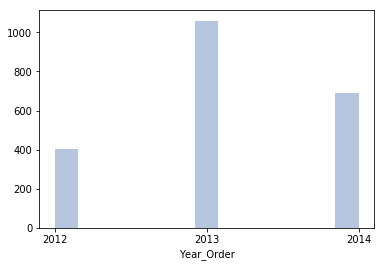

In [14]:
sns.distplot(df['Year_Order'], kde = False)
plt.xticks([2012,2013,2014])
plt.show()

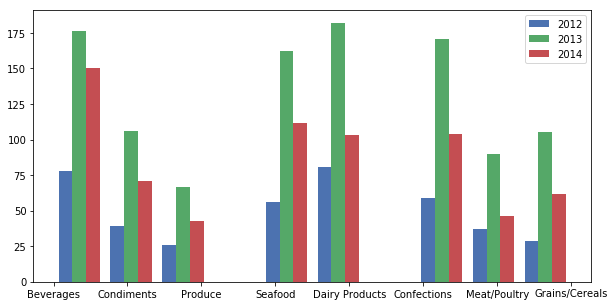

In [15]:
Orders_by_Year = []

for i, year in enumerate(df.Year_Order.unique()):
    Orders_by_Year.append(df[df.Year_Order == year].CategoryName) 
fig = plt.figure(figsize =(10,5))
plt.hist(Orders_by_Year, label =['2012', '2013','2014'])
plt.legend()
plt.show()
#     sns.countplot(x='CategoryName',  data =Orders_by_Year[2012])

# sns.countplot(x='CategoryName',  data =Orders_by_Year[2013])   
# Orders_by_Year[2012].columns

In [16]:
df.Price_total.describe()

count     2155.000000
mean       672.560237
std       1110.261427
min          6.000000
25%        170.500000
50%        380.000000
75%        760.000000
max      15810.000000
Name: Price_total, dtype: float64

No handles with labels found to put in legend.


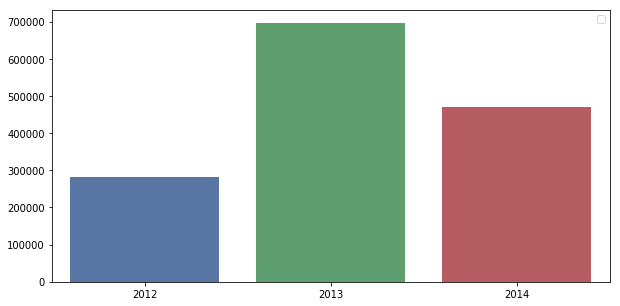

In [17]:
TotalSales_Year = []

for i, year in enumerate(df.Year_Order.unique()):
    TotalSales_Year.append(sum(df[df.Year_Order == year].Price_total)) 
fig = plt.figure(figsize =(10,5))
sns.barplot(x=['2012', '2013','2014'],y=TotalSales_Year)
plt.legend()
plt.show()
#     sns.countplot(x='CategoryName',  data =Orders_by_Year[2012])

# sns.countplot(x='CategoryName',  data =Orders_by_Year[2013])   
# Orders_by_Year[2012].columns

### Has the total amount of spending per order in average increased over years?
Conducting Wech's t-test 

$H_0$ : The average of total amount of spending per order in one year ($\mu_1$) and in its previous year ($\mu_0$) has not changed.
$$ \large\mu_1 = \mu_0$$
$H_a$ : The average of total amount of spending per order in one year is more than in its previous year. 
$$ \large\mu_1 > \mu_0$$
1) 2013 ($\mu_1$) vs. 2012 ($\mu_0$)

2) 2014 ($\mu_1$) vs. 2013 ($\mu_0$)

2012 Total amount per order
count      152.000000
mean      1862.137171
std       2121.815144
min         60.000000
25%        559.750000
50%       1319.550000
75%       2456.062500
max      15353.600000
Name: Price_total, dtype: float64 

2013 Total amount per order
count      408.000000
mean      1707.233137
std       1914.725381
min         12.500000
25%        518.600000
50%       1182.600000
75%       2214.187500
max      14366.500000
Name: Price_total, dtype: float64 

2014 Total amount per order
count      270.000000
mean      1739.893852
std       2427.355997
min         30.000000
25%        508.500000
50%        932.025000
75%       1959.107500
max      17250.000000
Name: Price_total, dtype: float64 



C:\Users\woogu\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Total Amount Per Order By Year')

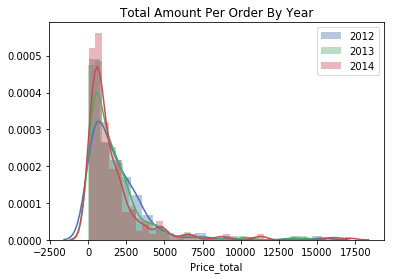

In [18]:
''' do people spend less money per order?
    1)Divide df by years
    2)Collect by order using OrderId
    3)check for outliers
    4)conduct Welch's ttest
    '''

Orders_by_Year ={}
Total_per_Order =[]
for i, year in enumerate(df.Year_Order.unique()):
    Orders_by_Year[year] = df[df.Year_Order == year]
    Total_per_Order.append(Orders_by_Year[year].groupby('OrderId').Price_total.sum())
    print(year,'Total amount per order')
    print(Total_per_Order[i].describe(),'\n')
    sns.distplot(Total_per_Order[i], label = str(year))
plt.legend()
plt.title('Total amount per order by year'.title())
 

In [19]:

#Investigate Percentiles to investigate outliers 
for q in np.linspace(0.8,1,num=21):
    q2012 = round(Total_per_Order[0].quantile(q=q),2)
    q2013 = round(Total_per_Order[1].quantile(q=q),2)
    q2014 = round(Total_per_Order[2].quantile(q=q),2)
    print('{}th percentile:\t2012:{}\t2013:{}\t2014:{}'.format(round(q,2), q2012, q2013,q2014 ))

0.8th percentile:	2012:2839.33	2013:2496.75	2014:2236.04
0.81th percentile:	2012:2854.75	2013:2558.35	2014:2352.68
0.82th percentile:	2012:2903.88	2013:2625.23	2014:2429.17
0.83th percentile:	2012:2974.91	2013:2712.4	2014:2631.75
0.84th percentile:	2012:3087.34	2013:2763.18	2014:2737.78
0.85th percentile:	2012:3131.17	2013:2827.11	2014:2835.7
0.86th percentile:	2012:3178.46	2013:2942.18	2014:2977.4
0.87th percentile:	2012:3273.51	2013:3121.33	2014:3108.1
0.88th percentile:	2012:3416.26	2013:3359.5	2014:3514.05
0.89th percentile:	2012:3556.28	2013:3432.97	2014:3612.7
0.9th percentile:	2012:3622.88	2013:3626.4	2014:3743.2
0.91th percentile:	2012:3707.1	2013:3908.79	2014:4345.77
0.92th percentile:	2012:3898.5	2013:4163.23	2014:4689.64
0.93th percentile:	2012:4219.36	2013:4331.61	2014:4776.57
0.94th percentile:	2012:4557.69	2013:4609.34	2014:4927.15
0.95th percentile:	2012:4832.37	2013:4832.81	2014:5866.64
0.96th percentile:	2012:5190.96	2013:5193.64	2014:6580.71
0.97th percentile:	2012:65

In [20]:

print(f'Comparison of the average of total amount of spending  for year 2013 and 2012')
print(f'Median Values: \t2012:{round(Total_per_Order[0].median(),2)} \t2013:{round(Total_per_Order[1].median(),2)}')
print(f'Mean Values: \ts2012:{round(Total_per_Order[0].mean(),2)} \t2013:{round(Total_per_Order[1].mean(),2)}')
print(f'Sample sizes: \t2012:{len(Total_per_Order[0])} \t2013:{len(Total_per_Order[1])}')
print(f"Wech's t-test p-value:{fs.p_value_welch_ttest(Total_per_Order[1],Total_per_Order[0])}")

Comparison of the average of total amount of spending  for year 2013 and 2012
Median Values: 	2012:1319.55 	2013:1182.6
Mean Values: 	s2012:1862.14 	2013:1707.23
Sample sizes: 	2012:152 	2013:408
Wech's t-test p-value:0.21561018525422626


In [21]:

print(f'Comparison of the average of total amount of spending  for year 2014 and 2013')
print(f'Median Values: \t2013:{round(Total_per_Order[1].median(),2)} \t2014:{round(Total_per_Order[2].median(),2)}')
print(f'Mean Values: \t2013:{round(Total_per_Order[1].mean(),2)} \t2014:{round(Total_per_Order[2].mean(),2)}')
print(f'Sample sizes: \t2013:{len(Total_per_Order[1])} \t2014:{len(Total_per_Order[2])}')
print(f"Wech's t-test p-value:{fs.p_value_welch_ttest(Total_per_Order[2],Total_per_Order[1])}")

Comparison of the average of total amount of spending  for year 2014 and 2013
Median Values: 	2013:1182.6 	2014:932.02
Mean Values: 	2013:1707.23 	2014:1739.89
Sample sizes: 	2013:408 	2014:270
Wech's t-test p-value:0.4262312955523925


Using $\alpha = 0.05$, we fail to reject both null hypotheses. That means, we can't find enough evidence to conclude that there were significant change in how each customer spent per order for those three years.  

So far, we see that the total number of sales had increased from 2012 to 2013 then decreased from 2013 to 2014 and it was also consistent in sales by categories. 

However, we couldn't find enough evidence that changes in the average spending per order was significant.


### Customer Retention Rate

I would like to investigate the retention rate for customers. 
Divide `CustomerId` into three groups depending on since which year they have made purchases. 

In [22]:
df.columns

Index(['Id', 'ProductName', 'SupplierId', 'CategoryId', 'QuantityPerUnit',
       'UnitPrice', 'UnitsInStock', 'UnitsOnOrder', 'ReorderLevel',
       'Discontinued', 'Id_1', 'OrderId', 'ProductId', 'UnitPrice_1',
       'Quantity', 'Discount', 'Id_2', 'CategoryName', 'Description', 'Id_3',
       'CustomerId', 'EmployeeId', 'OrderDate', 'RequiredDate', 'ShippedDate',
       'ShipVia', 'Freight', 'ShipName', 'ShipAddress', 'ShipCity',
       'ShipRegion', 'ShipPostalCode', 'ShipCountry', 'Price_total',
       'Year_Order'],
      dtype='object')

In [23]:
query ="""
            SELECT CustomerId, Year_Order, COUNT(DISTINCT(OrderId)) as Order_Counts, SUM(Price_total) as Total$
            FROM df
            GROUP BY 1,2
            """
customers = pysqldf(query)
customers.head()
# df.groupby(['CustomerId','Year_Order']).OrderId.count()

,CustomerId,Year_Order,Order_Counts,Total$
0,ALFKI,2013,3,2294.00
1,ALFKI,2014,3,2302.20
2,ANATR,2012,1,111.00
3,ANATR,2013,2,799.75
4,ANATR,2014,1,514.40


In [24]:
c12 = customers.query('Year_Order == 2012')
c13 = customers.query('Year_Order == 2013')
c14 = customers.query('Year_Order == 2014')
q = """SELECT * 
        FROM c14 
        LEFT JOIN c13 USING(CustomerId)
        LEFT JOIN c12 using(CustomerId)"""
customer_history = pysqldf(q)
customer_history.columns = rename_dup_columns(customer_history)
customer_history.head()

There are 3 columns with name:Year_Order
There are 3 columns with name:Order_Counts
There are 3 columns with name:Total$


C:\Users\woogu\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: 'get_duplicates' is deprecated and will be removed in a future release. You can use idx[idx.duplicated()].unique() instead
  from ipykernel import kernelapp as app
C:\Users\woogu\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: 'get_duplicates' is deprecated and will be removed in a future release. You can use idx[idx.duplicated()].unique() instead
  app.launch_new_instance()


,CustomerId,Year_Order,Order_Counts,Total$,Year_Order_1,Order_Counts_1,Total$_1,Year_Order_2,Order_Counts_2,Total$_2
0,ALFKI,2014,3,2302.20,2013.0,3.0,2294.00,NaN,NaN,NaN
1,ANATR,2014,1,514.40,2013.0,2.0,799.75,2012.0,1.0,111.00
2,ANTO,2014,1,660.00,2013.0,5.0,6452.15,2012.0,1.0,504.00
3,AROUT,2014,4,5838.50,2013.0,7.0,6702.25,2012.0,2.0,1723.75
4,BERGS,2014,5,8110.55,2013.0,10.0,14838.30,2012.0,3.0,5406.90


In [25]:
customer_history.Year_Order_1.fillna(2013, inplace =True)
customer_history.Order_Counts_1.fillna(0,inplace =True)
customer_history['Total$_1'].fillna(0,inplace = True)
customer_history.Year_Order_2.fillna(2012, inplace =True)
customer_history.Order_Counts_2.fillna(0,inplace =True)
customer_history['Total$_2'].fillna(0,inplace = True)

In [26]:
customer_history.describe()

,Year_Order,Order_Counts,Total$,Year_Order_1,Order_Counts_1,Total$_1,Year_Order_2,Order_Counts_2,Total$_2
count,81.0,81.000000,81.000000,81.0,81.000000,81.000000,81.0,81.000000,81.000000
mean,2014.0,3.333333,5799.646173,2013.0,4.691358,8002.248395,2012.0,1.728395,3335.295062
std,0.0,2.207940,8925.907057,0.0,3.231261,11891.984784,0.0,1.573311,4780.881599
min,2014.0,1.000000,45.000000,2013.0,0.000000,0.000000,2012.0,0.000000,0.000000
25%,2014.0,1.000000,1117.000000,2013.0,2.000000,1410.000000,2012.0,1.000000,111.000000
50%,2014.0,3.000000,2371.000000,2013.0,4.000000,5217.650000,2012.0,1.000000,1450.000000
75%,2014.0,4.000000,5994.060000,2013.0,6.000000,9860.450000,2012.0,3.000000,4269.400000
max,2014.0,11.000000,42806.250000,2013.0,17.000000,65762.450000,2012.0,6.000000,21487.760000


In [61]:
new_2014 = customer_history.query('Order_Counts_2 ==0 &Order_Counts_1 ==0 ')
print(f'There are {len(new_2014)} new customers in 2014.')

There are 1 new customers in 2014.


In [28]:
customer_history.query('Order_Counts_2 ==0 &Order_Counts_1 !=0 ')

,CustomerId,Year_Order,Order_Counts,Total$,Year_Order_1,Order_Counts_1,Total$_1,Year_Order_2,Order_Counts_2,Total$_2
0,ALFKI,2014,3,2302.20,2013.0,3.0,2294.00,2012.0,0.0,0.0
5,BLAUS,2014,3,2160.00,2013.0,4.0,1079.80,2012.0,0.0,0.0
11,CACTU,2014,4,1576.80,2013.0,2.0,238.00,2012.0,0.0,0.0
14,CONSH,2014,1,931.50,2013.0,2.0,985.00,2012.0,0.0,0.0
21,FRANR,2014,2,2252.06,2013.0,1.0,920.10,2012.0,0.0,0.0
22,FRANS,2014,2,1296.00,2013.0,4.0,262.36,2012.0,0.0,0.0
26,GOURL,2014,2,497.00,2013.0,7.0,8460.23,2012.0,0.0,0.0
27,GREAL,2014,5,10562.58,2013.0,6.0,9148.55,2012.0,0.0,0.0
35,LAUGB,2014,1,187.00,2013.0,2.0,405.50,2012.0,0.0,0.0
37,LETSS,2014,1,1450.60,2013.0,3.0,2039.42,2012.0,0.0,0.0


In [91]:
new_2013 = customer_history.query('Order_Counts_2 ==0 &Order_Counts_1 !=0 ')
print(f'There are {len(new_2013)} new customers in 2013.')

There are 19 new customers in 2013.


In [57]:
churn_2013 = customer_history.query('Order_Counts_2 !=0 &Order_Counts_1 ==0 & Order_Counts==0')
print(f'There is {len(churn_2013)} churn rate in 2013.' )

There is 0 churn rate in 2013.


In [69]:
churn_2014= customer_history.query('Order_Counts==0')
print(f'There is {len(churn_2014)} churn rate in 2013.' )

There is 0 churn rate in 2013.


In [83]:
customer_history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81 entries, 0 to 80
Data columns (total 10 columns):
CustomerId        81 non-null object
Year_Order        81 non-null int64
Order_Counts      81 non-null int64
Total$            81 non-null float64
Year_Order_1      81 non-null float64
Order_Counts_1    81 non-null float64
Total$_1          81 non-null float64
Year_Order_2      81 non-null float64
Order_Counts_2    81 non-null float64
Total$_2          81 non-null float64
dtypes: float64(7), int64(2), object(1)
memory usage: 6.4+ KB


In [93]:
customer_counts_2014 = len(customer_history.query('Order_Counts !=0'))
customer_counts_2013 = len(customer_history.query('Order_Counts_1 !=0 | Order_Counts_2 !=0 '))
retention_rate2014= round((customer_counts_2014 - len(new_2014))/customer_counts_2013*100,2)
print(f'The retention rate in 2014 is {retention_rate2014}%' )

The retention rate in 2014 is 100.0%


In [101]:
customer_counts_2013 = len(customer_history.query('Order_Counts_1 !=0'))
customer_counts_2012 = len(customer_history.query('Order_Counts_2 !=0  '))
retention_rate2013= round((customer_counts_2013 - len(new_2013))/customer_counts_2012*100,2)
print(f'The retention rate in 2013 is {retention_rate2013}%' )

The retention rate in 2013 is 98.36%


In [97]:
customer_history.query('Order_Counts_2 !=0 & Order_Counts_1 ==0 ')

,CustomerId,Year_Order,Order_Counts,Total$,Year_Order_1,Order_Counts_1,Total$_1,Year_Order_2,Order_Counts_2,Total$_2
59,ROMEY,2014,2,726.89,2013.0,0.0,0.0,2012.0,3.0,926.69


In [99]:
print(customer_counts_2013,len(new_2013),customer_counts_2012)

79 19 61


* There are only one new customer in 2014 whereas 19 new customers in 2013. 
* The retention rates for 2014 and 2013 were 100% and 98% respectively.  

This observations explain the reason for the increased total sales in 2013 explains.
However, we need to investigate the reason for the decrease in total sales in 2014. 

We are going to test if the average number of orders per customer changed from 2013 to 2014. 

In [166]:
compare = {}
compare['2013']=customer_history.Order_Counts_1
compare['2014']=customer_history.Order_Counts
welch_summary(compare)

Comparison of the average of total order per year  for year 2013 and 2014
Median Values: 	2013:4.0 	2014:3.0
Mean Values: 	2013:4.69 	2014:3.33
Sample sizes: 	2013:81 	2014:81


Welch's t-test p-value:0.00109
Test result:	There is statistically significant difference 
 		between the means of two groups with 50.0% confidence level.
Effect size:	0.49
Level of effect size:	small


(0.00109, 0.49)

The change in the average number of orders is significant.

Look at what was changed from 2012 to 2013. And 2013 to 2014

In [35]:
categories ={}
for i in list(df['CategoryId'].unique()):
    categories[i]=df[df['CategoryId']==i].CategoryName.unique()[0]

In [36]:
categories

{1: 'Beverages',
 2: 'Condiments',
 7: 'Produce',
 6: 'Meat/Poultry',
 8: 'Seafood',
 4: 'Dairy Products',
 3: 'Confections',
 5: 'Grains/Cereals'}

In [37]:
df[df['CategoryId']==1].CategoryName.unique()[0]

'Beverages'

## Related to shipping date and order dates depending on the category of the ordered product
* Need to change str to date time objects to calculate how long it takes to get shipping? 

In [38]:
df.ShipRegion.value_counts()

Western Europe     745
North America      427
South America      355
British Isles      190
Northern Europe    143
Southern Europe    137
Central America     72
Scandinavia         70
Eastern Europe      16
Name: ShipRegion, dtype: int64

In [39]:
df.query("ShipRegion == 'North America'").CategoryName.value_counts()

Confections       77
Beverages         72
Dairy Products    69
Seafood           61
Grains/Cereals    43
Condiments        43
Meat/Poultry      41
Produce           21
Name: CategoryName, dtype: int64

In [40]:
test =df.query("CategoryName in ['Seafood','Dairy Products','Meat/Poultry', 'Produce']  ")
test.loc[:,['OrderDate','ShippedDate', 'RequiredDate']]

,OrderDate,ShippedDate,RequiredDate
136,2012-07-22,2012-07-25,2012-08-19
137,2012-12-17,2012-12-23,2013-01-14
138,2013-02-27,2013-02-28,2013-03-27
139,2013-03-11,2013-03-18,2013-04-08
140,2013-04-18,2013-04-21,2013-05-16
141,2013-05-23,2013-05-27,2013-06-20
142,2013-07-07,2013-07-16,2013-07-21
143,2013-07-22,2013-07-25,2013-08-19
144,2013-08-15,2013-08-21,2013-09-12
145,2013-10-06,2013-10-09,2013-11-03


## Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?

In [41]:
df_tables['OrderDetail'].Discount.unique()

array([0.  , 0.15, 0.05, 0.2 , 0.25, 0.1 , 0.02, 0.03, 0.04, 0.06, 0.01])

In [42]:
query = """ SELECT DISTINCT(Discount) FROM OrderDetail ORDER BY Discount DESC"""
perc_disc = pd.read_sql(query,conn).Discount

In [43]:
perc_disc

0     0.25
1     0.20
2     0.15
3     0.10
4     0.06
5     0.05
6     0.04
7     0.03
8     0.02
9     0.01
10    0.00
Name: Discount, dtype: float64

In [44]:
query = """ SELECT * FROM OrderDetail ORDER BY Discount DESC """
pd.read_sql(query,conn).describe()

,OrderId,ProductId,UnitPrice,Quantity,Discount
count,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000
mean,10659.375870,40.793039,26.218520,23.812993,0.056167
std,241.378032,22.159019,29.827418,19.022047,0.083450
min,10248.000000,1.000000,2.000000,1.000000,0.000000
25%,10451.000000,22.000000,12.000000,10.000000,0.000000
50%,10657.000000,41.000000,18.400000,20.000000,0.000000
75%,10862.500000,60.000000,32.000000,30.000000,0.100000
max,11077.000000,77.000000,263.500000,130.000000,0.250000


In [45]:
subsets ={}
for disc in perc_disc:
    percent = int(disc*100)
    subsets[percent] = df[df.Discount == disc].Quantity
    subsets[percent] = subsets[percent].reset_index().drop('index', axis =1)
    print(f'number of sales with {percent}% discount :', len(subsets[percent]))
#     lab =str(percent)+'%'
    
#     sns.distplot(subsets[percent], label = lab)
#     plt.legend()

number of sales with 25% discount : 154
number of sales with 20% discount : 161
number of sales with 15% discount : 157
number of sales with 10% discount : 173
number of sales with 6% discount : 1
number of sales with 5% discount : 185
number of sales with 4% discount : 1
number of sales with 3% discount : 3
number of sales with 2% discount : 2
number of sales with 1% discount : 1
number of sales with 0% discount : 1317


C:\Users\woogu\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


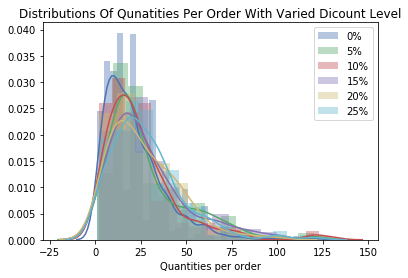

In [46]:
percents_testing = list(range(0,30,5))
for percent in percents_testing:
    lab =str(percent)+'%'
    sns.distplot(subsets[percent], label = lab)
    plt.xlabel('Quantities per order')
    plt.legend()
    plt.title('Distributions of Qunatities per order with varied dicount level'.title())

The graph above shows that the highest peak (mean) of plots shift slightly right as the discount increases. 

We want to test the differences in means between no discount and varied discount levels are statistically significant. 
Let us name the group of orders with no discount as control set and its mean in quantity per order as $\mu_0$. Then name the groups with different  discount levels (5% ~ 25%) as experimental set and their means as $\mu_1$.

We want to conduct one-sided Welch's t-test as:
* we compare two independent sets with different sizes and variances; 
* we expect the discount would encourage customers to buy more not less. 

Null hypothesis($H_0$):

$$\Large\mu_1 \le \mu_0$$ 

Alternative hypothesis($H_a$):

$$\Large\mu_1 > \mu_0$$



In [47]:
discounts = percents_testing[1:]
no_disc = subsets[0]
for discount in discounts:
    disc = subsets[discount]
    p = p_value_welch_ttest(no_disc,disc, two_sided = False)
    print(f"The p-value to test significance of means in qunatities of an order \n between sets with no discount and {discount}% discount is {np.round(p[0],5)}.")
    if p < 0.05:
        print(f"With 95% confidence, the increase in quantities per order \n with {discount} % discount is statistically significant.\n")

The p-value to test significance of means in qunatities of an order 
 between sets with no discount and 5% discount is 0.00014.
With 95% confidence, the increase in quantities per order 
 with 5 % discount is statistically significant.

The p-value to test significance of means in qunatities of an order 
 between sets with no discount and 10% discount is 0.01873.
With 95% confidence, the increase in quantities per order 
 with 10 % discount is statistically significant.

The p-value to test significance of means in qunatities of an order 
 between sets with no discount and 15% discount is 9e-05.
With 95% confidence, the increase in quantities per order 
 with 15 % discount is statistically significant.

The p-value to test significance of means in qunatities of an order 
 between sets with no discount and 20% discount is 0.00041.
With 95% confidence, the increase in quantities per order 
 with 20 % discount is statistically significant.

The p-value to test significance of means in qun

In [105]:
effect_sizes ={}
# m0 = no_disc.mean().reset_index()[0][0]
# std0 = no_disc.std().reset_index()[0][0]
for discount in discounts:
#     m1 = subsets[discount].mean().reset_index()[0][0]
    effect = Cohen_d(subsets[discount],no_disc)
    effect_sizes[discount]=effect

Text(0, 0.5, 'Effect Sizes')

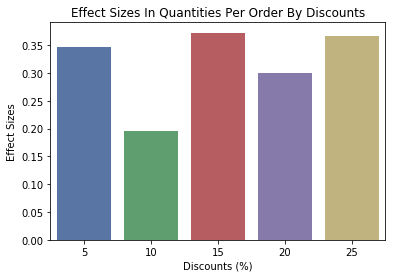

In [106]:
sns.barplot(x=discounts, y=list(effect_sizes.values()))
plt.title('Effect sizes in quantities per order by discounts'.title())
plt.xlabel('discounts (%)'.title())
plt.ylabel("effect sizes".title())

In [50]:
print(m0, subsets[5].mean().reset_index()[0][0])

21.715261958997722 28.01081081081081


The effect sizes in quantities of products per order by discounts are small. 
Sales with small discounts result in quantity changes in orders as the one with larger discounts. With 5% discounts, about 15% of a group is estimated to order more ( about 6 more units)

https://rpsychologist.com/d3/cohend/

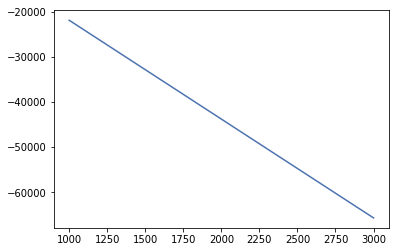

In [51]:
x=np.linspace(1000,3000,num = 10)
y =(8*22)*x-(8-5)*(22*x*0.85+28*x*0.15)
y1=x-(22*x*0.85+28*x*0.15)
# print((100*0.08*22)*1000-(100*0.08-100*0.05)*(22*1000*0.85+28*1000*0.15))
plt.plot(x,y1)

In [52]:
0.15*6

0.8999999999999999

In [53]:
power_analysis = 

SyntaxError: invalid syntax (<ipython-input-53-839466aaf61c>, line 1)

## Do customer come back based on shipping/ product?

## Exploring for questions to test

In [ ]:
df_tables.keys()

In [ ]:
df_tables['Order'].head()

In [ ]:
df_tables['Order'].ShipCountry.value_counts()

In [ ]:
df_tables['Product'].head()

In [ ]:
df_tables['Shipper'].info()

In [ ]:
df_tables['Employee'].HireDate